## Import data

In [2]:
import pandas as pd # pyright: ignore[reportMissingModuleSource]

emg_cols = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8']
GESTURE_COL = "CurrentGestures"
THRESHOLD_COL = "Threshold"

df = pd.read_csv("../data3.csv", sep=";")
print(df.shape)  # dimensions
print(df.info())  # types and missing values

(138004, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138004 entries, 0 to 138003
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Threshold        138004 non-null  object
 1   EMG1             138004 non-null  int64 
 2   EMG2             138004 non-null  int64 
 3   EMG3             138004 non-null  int64 
 4   EMG4             138004 non-null  int64 
 5   EMG5             138004 non-null  int64 
 6   EMG6             138004 non-null  int64 
 7   EMG7             138004 non-null  int64 
 8   EMG8             138004 non-null  int64 
 9   Framecount       138004 non-null  int64 
 10  CurrentGestures  138004 non-null  object
 11  SessionID        138004 non-null  object
 12  Timestamp        138004 non-null  object
dtypes: int64(9), object(4)
memory usage: 13.7+ MB
None


## Clean data
### Manage missing data

In [1]:
df = df.drop_duplicates()  # remove duplicate rows
df = df.dropna() # remove rows with missing values

NameError: name 'df' is not defined

### Standardize data

In [ ]:
from sklearn.preprocessing import StandardScaler # pyright: ignore[reportMissingModuleSource]

# Standardization
scaler = StandardScaler()
standard_data = scaler.fit_transform(df[emg_cols])

### Encode label

In [ ]:
from sklearn.preprocessing import LabelEncoder # pyright: ignore[reportMissingModuleSource]

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df[GESTURE_COL])

print("\nEncoded labels:")
print(df[['label', GESTURE_COL]].drop_duplicates())


Encoded labels:
        label CurrentGestures
0           0            fist
27026       1           pinch
53852       3      wrist-back
80744       4   wrist-forward
106544      2            rest


### Split data

In [ ]:
from sklearn.model_selection import train_test_split

# Use the cleaned and prepared dataframe from previous cells
# Separate features (X) and labels (y)
X = standard_data
y = df['label']

# 3. Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val):
    # Evaluate on validation set
    y_pred = model.predict(X_val)
    print("Validation accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
	
    # Cross-validation
    scores = cross_val_score(model, X_val, y_val, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())


    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    # ROC Curve
    y_val_bin = label_binarize(y_val, classes=model.classes_)
    probs_full = model.predict_proba(X_val)

    plt.figure()
    for i in range(y_val_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs_full[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

## Artificial Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

def create_mlp_model(hidden_layer_sizes, activation, alpha, learning_rate_init):
    return MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver='adam',
        alpha=alpha,                                    # L2 regularization
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        validation_fraction=0.2,                        # Use 20% of training data for validation
        early_stopping=True,                            # Stop when validation score stops improving
        n_iter_no_change=50,                            # Stop after 50 iterations without improvement
        random_state=42,
        batch_size='auto'
    )

## Hyperparameter optimization

In [ ]:
import optuna

def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', ['32', '64', '64-32', '128-64'])
    layer_map = {
        '32': (32,),
        '64': (64,),
        '64-32': (64, 32),
        '128-64': (128, 64)
    }
    hidden_layer_sizes = layer_map[hidden_layer_sizes]

    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        early_stopping=True,
        random_state=42
    )

    scores = cross_val_score(mlp, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()


# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)


# Results Analysis
df_results = study.trials_dataframe()
df_sorted = df_results.sort_values('value', ascending=False)
print("\n===== Top 5 trials =====\n")
print(df_sorted[['value', 'params_hidden_layer_sizes', 'params_activation', 'params_alpha', 'params_learning_rate_init']].head())


# Plot accuracy vs learning rate
plt.scatter(df_results['params_learning_rate_init'], df_results['value'])
plt.xscale('log')
plt.xlabel("Learning Rate Init")
plt.ylabel("Accuracy (CV mean)")
plt.title("Impact of Learning Rate on Accuracy")
plt.show()

ModuleNotFoundError: No module named 'optuna'

### Get best parameters

In [ ]:
best_params = study.best_trial.params
best_params['hidden_layer_sizes'] = [int(x) for x in best_params['hidden_layer_sizes'].split('-')]

print("Best parameters:", best_params)

Best parameters: {'hidden_layer_sizes': [64, 32], 'activation': 'relu', 'alpha': 0.002737774412777119, 'learning_rate_init': 0.0008820622180620331}


### Train final model

Training improved neural network...
Training completed!
Number of iterations: 123
Final loss: 0.5457

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.7848896188589923
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      3991
           1       0.63      0.67      0.65      4038
           2       0.86      0.85      0.85      4731
           3       0.85      0.86      0.85      4067
           4       0.89      0.89      0.89      3874

    accuracy                           0.78     20701
   macro avg       0.78      0.78      0.78     20701
weighted avg       0.79      0.78      0.79     20701

Cross-validation scores: [0.77372615 0.77487923 0.76642512 0.77125604 0.7736715 ]
Mean accuracy: 0.7719916074322173


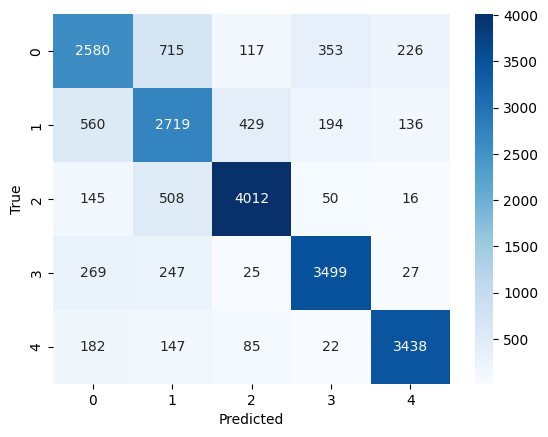

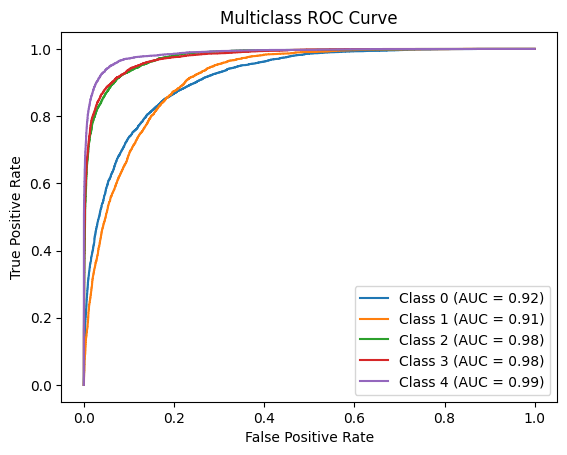


============== Test Accuracy: 0.781459832858316 ==============
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      4093
           1       0.64      0.68      0.66      4140
           2       0.85      0.85      0.85      4659
           3       0.83      0.85      0.84      3960
           4       0.90      0.89      0.89      3849

    accuracy                           0.78     20701
   macro avg       0.78      0.78      0.78     20701
weighted avg       0.78      0.78      0.78     20701



In [ ]:
best_mlp = create_mlp_model(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
)

print("Training improved neural network...")
best_mlp.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {best_mlp.n_iter_}")
print(f"Final loss: {best_mlp.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(best_mlp, X_val, y_val)

# Evaluate on test set
y_pred = best_mlp.predict(X_test)
print("\n============== Test Accuracy:", accuracy_score(y_test, y_pred), "==============")
print(classification_report(y_test, y_pred))

## Model export

In [ ]:
# train_export.py
import json
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime

FEATURE_NAMES = emg_cols  # Use the original EMG column names
CLASS_NAMES = encoder.classes_.tolist()


df = pd.read_csv("../data.csv", sep=";")
df = df.drop_duplicates()  # remove duplicate rows
df = df.dropna() # remove rows with missing values


# Separate features and labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
print("\nEncoded labels:")
print(df[['label', 'gesture']].drop_duplicates())
Y = df['label']
X = df[emg_cols]


X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size=0.3, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", create_mlp_model(
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation'],
        alpha=best_params['alpha'],
        learning_rate_init=best_params['learning_rate_init'],
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_eval)

metrics = {
    "accuracy": float(accuracy_score(y_eval, y_pred)),
    "report": classification_report(y_eval, y_pred, target_names=CLASS_NAMES, output_dict=True),
}

timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
model_dir = f"../models/gesture_recognition_1.2.7_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

# 1) Save pipeline
joblib.dump(pipe, f"{model_dir}/pipeline.joblib")

# 2) Save config (schema, classes, thresholds, etc.)
config = {
    "feature_names": FEATURE_NAMES,
    "class_names": CLASS_NAMES,
    "top_k": 2,
    "abstain_threshold": 0.6,  # below this max prob => "unknown"
    "random_state": 42,
    "library": {"sklearn": ">=1.2"},
}
with open(f"{model_dir}/config.json", "w") as f:
    json.dump(config, f, indent=2)

# 3) Save metrics
with open(f"{model_dir}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Model exported to:", model_dir)



Encoded labels:
       label        gesture
0          0           fist
6474       1          pinch
14788      2           rest
26702      3     wrist-back
40248      4  wrist-forward
Model exported to: ../models/gesture_recognition_1.2.7_20250822T125046Z
